In [28]:
import pandas as pd
import numpy as np
pd.set_option('display.max_row',100)
pd.set_option('display.max_column',100)

In [2]:
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

# Pre-process Pupil Data

In [5]:
from edfreader import read_edf
from pupil_preprocess import deblink_pupil, remove_outliers, smooth_pupil, interpolate_pupil, downsample_pupil, baseline_correction

In [34]:
path = 'data/_Forced_Response_scene_contrast_2022_Jul_26_1425.asc'
data = read_edf(path, start='free fixation start', stop='free search end')
data = pd.DataFrame(data)

In [39]:
data.events[0]

{'Sfix': [526130, 526364, 527596, 527782, 528036, 528176],
 'Ssac': [525950, 526356, 527568, 527758, 527994, 528166],
 'Sblk': [525974],
 'Efix': [[525038, 525948, 912, 773.7, 622.0],
  [526130, 526354, 226, 746.8, 609.3],
  [526364, 527566, 1204, 770.7, 603.1],
  [527596, 527756, 162, 866.0, 731.0],
  [527782, 527992, 212, 791.5, 589.7],
  [528036, 528164, 130, 858.6, 931.4]],
 'Esac': [[525950, 526128, 180, 769.8, 604.8, 737.8, 555.8],
  [526356, 526362, 8, 748.1, 607.0, 768.4, 604.5],
  [527568, 527594, 28, 774.6, 608.7, 868.3, 715.9],
  [527758, 527780, 24, 861.3, 729.1, 804.3, 613.4],
  [527994, 528034, 42, 792.3, 591.4, 863.3, 932.6],
  [528166, 528174, 10, 858.1, 921.7, 860.4, 893.2]],
 'Eblk': [[525974, 526082, 110]],
 'msg': [[525551, 'free fixation start Block_0 Trial_0\n'],
  [527101, 'free fixation end Block_0 Trial_0\n'],
  [527175, 'free search start Block_0 Trial_0\n']]}

In [118]:
from glob import glob
from cili.util import *
from pupil_preprocess import *

samp_freq = 500
trial_events = ['start_trial', 'end_trial','start_fixdot', 'end_fixdot','start_searcharray', 'end_searcharray']
use_eye = 'left'

eye_df = pd.DataFrame()
eye_df_resamp = pd.DataFrame()

for files in glob('Data//Experiment//*.asc'):
    
    # get subject nr
    subject_nr = int(filter(str.isdigit, files))
    
    # load eyelink data
    print 'loading subject %d' % subject_nr
    samps, events = load_eyelink_dataset(files)
    
    # calculate correlaltion between eyes
    #correlation_eye(samps, 'pup_l','pup_r')
    
    # select which eye to process
    samps = select_eye(data=samps, use_eye = use_eye)
    
    # get event timestamp
    trial_event_times = trial_events_from_cili(events.MSG, trial_events)
    trial_event_times['twosec'] = trial_event_times.end_fixdot-2000
    
    # extract data
    print '......extracting data'
    extracted_samps = trial_event_times.groupby('trial_id').apply(select_data, 
                                                              eye_data = samps, 
                                                              start='start_fixdot', 
                                                              end='end_fixdot', 
                                                              align_on='start_fixdot').reset_index()
    
    # check signal loss
    #print '......checking signal loss'
    #extracted_samps = extracted_samps.groupby('trial_id').apply(check_tracking_loss, 
    #                                                            column='pup', 
    #                                                            threshold=.3, 
    #                                                            missing_indicator=0)
    
    # deblink
    print '......deblinking'
    deblink_samps = extracted_samps.groupby('trial_id').apply(deblink_pupil, column='pup', samp_freq=samp_freq)
    
    # remove outliers
    print '......removing outliers'
    rm_samps = deblink_samps.groupby('trial_id').apply(remove_outliers, 
                                                                column_pup='pup_deblink', 
                                                                column_x='x',column_y='y', 
                                                                left=459, right=565, top=331, bottom=437)
    
    # smooth
    print '......smoothing'
    smooth_samps = rm_samps.groupby('trial_id').apply(smooth_pupil, column='pup_deblink_rm')
    
    # interpolate
    print '......interpolating'
    interp_samps = smooth_samps.groupby('trial_id').apply(interpolate_pupil, column='pup_deblink_rm_smooth', method='linear')
    
    # downsample
    print '......downsampling'
    resamp_samps = interp_samps.groupby('trial_id').apply(downsample_pupil, 
                                                            pup_col='pup_deblink_rm_smooth_interp',
                                                            time_col = 'onset_aligned',
                                                            bin_size='100ms').reset_index()
    interp_samps['subject_nr'] = subject_nr
    resamp_samps['subject_nr'] = subject_nr
    
    eye_df = eye_df.append(interp_samps)
    eye_df_resamp = eye_df_resamp.append(resamp_samps)
    
    print 'Done!\n'

loading subject 1
......extracting data
......deblinking
......removing outliers
......smoothing
......interpolating
......downsampling
Done!

loading subject 0
......extracting data
......deblinking
......removing outliers
......smoothing
......interpolating
......downsampling
Done!

loading subject 2
......extracting data
......deblinking
......removing outliers
......smoothing
......interpolating
......downsampling
Done!

loading subject 3
......extracting data
......deblinking
......removing outliers
......smoothing
......interpolating
......downsampling
Done!

loading subject 5
......extracting data
......deblinking
......removing outliers
......smoothing
......interpolating
......downsampling
Done!

loading subject 20
......extracting data
......deblinking
......removing outliers
......smoothing
......interpolating
......downsampling
Done!

loading subject 21
......extracting data
......deblinking
......removing outliers
......smoothing
......interpolating
......downsampling
Done

In [122]:
# save data
eye_df.to_pickle('pupil_size_df.pkl')

# save data
eye_df_resamp.to_pickle('pupil_size_df_resamp.pkl')

In [123]:
# read data
eye_df_resamp = pd.read_pickle('pupil_size_df_resamp.pkl')

In [124]:
# aggregate data
agg_pups = pd.pivot_table(eye_df, index=['subject_nr','trial_id'], 
                          values=['pup_deblink_rm_smooth_interp'], aggfunc=np.mean).reset_index()

# Combine with RT and Fixation Data

In [125]:
# read rt and fixation data
res = pd.read_csv('rt_and_fixation_data.csv')

In [126]:
res = res.merge(agg_pups, on=['subject_nr','trial_id'], how='left')

## Clean up trials

In [127]:
# no pupil acquired
res = res[~res.pup_deblink_rm_smooth_interp.isna()]

In [128]:
# tracking loss
res['low_tracking_ratio'] = res.tracking_loss.apply(lambda x: 1 if x>.30 else 0)
print (float(res.low_tracking_ratio.sum())/len(res))
res = res[res.low_tracking_ratio == 0].reset_index(drop=True)

0.0269945631559


In [129]:
# rt
from scipy.stats import zscore
res['zscore_rt'] = res.groupby(['subject_nr']).rt.transform(lambda x : zscore(x))
res['extreme_rt'] = res.zscore_rt.apply(lambda x: 1 if (x<-3) or (x>3) else 0)
print (float(res.extreme_rt.sum())/len(res))
res = res[res.extreme_rt==0].reset_index(drop=True)

0.0155935286856


In [130]:
# extreme pupil size
res['zscore_pup'] = res.groupby(['subject_nr']).pup_deblink_rm_smooth_interp.transform(lambda x : zscore(x))
res['extreme_pup'] = res.zscore_pup.apply(lambda x: 1 if (x<-3) or (x>3) else 0)
print (float(res.extreme_pup.sum())/len(res))
res = res[res.extreme_pup==0].reset_index(drop=True)

0.00402613688865


In [131]:
# percentage of trials
res.groupby('subject_nr').rt.count()/480

subject_nr
0     0.916667
1     0.987500
2     0.966667
3     0.983333
5     0.970833
6     0.966667
8     0.987500
9     0.970833
10    0.989583
12    0.979167
13    0.925000
14    0.975000
16    0.852083
17    0.985417
18    0.937500
19    0.941667
20    0.964583
21    0.981250
22    0.937500
23    0.983333
24    0.852083
26    0.970833
27    0.868750
28    0.979167
29    0.970833
30    0.972917
31    0.960417
33    0.935417
34    0.970833
35    0.904167
37    0.989583
38    0.983333
41    0.877083
Name: rt, dtype: float64

In [132]:
# subject level accuracy
res.groupby('subject_nr').correct.mean()

subject_nr
0     0.990909
1     0.930380
2     0.943966
3     0.959746
5     0.989270
6     0.976293
8     0.991561
9     0.920601
10    0.995789
12    0.963830
13    0.984234
14    0.982906
16    0.980440
17    0.991543
18    0.933333
19    0.977876
20    0.982721
21    0.987261
22    0.924444
23    0.995763
24    0.968215
26    0.965665
27    0.923261
28    0.963830
29    0.993562
30    0.974304
31    0.986985
33    0.984410
34    0.939914
35    0.976959
37    0.991579
38    0.978814
41    0.995249
Name: correct, dtype: float64

In [133]:
1-float(len(res))/len(pd.read_csv('rt_and_fixation_data.csv'))

0.04734848484848486

In [134]:
res.to_csv('data.csv',index=False)

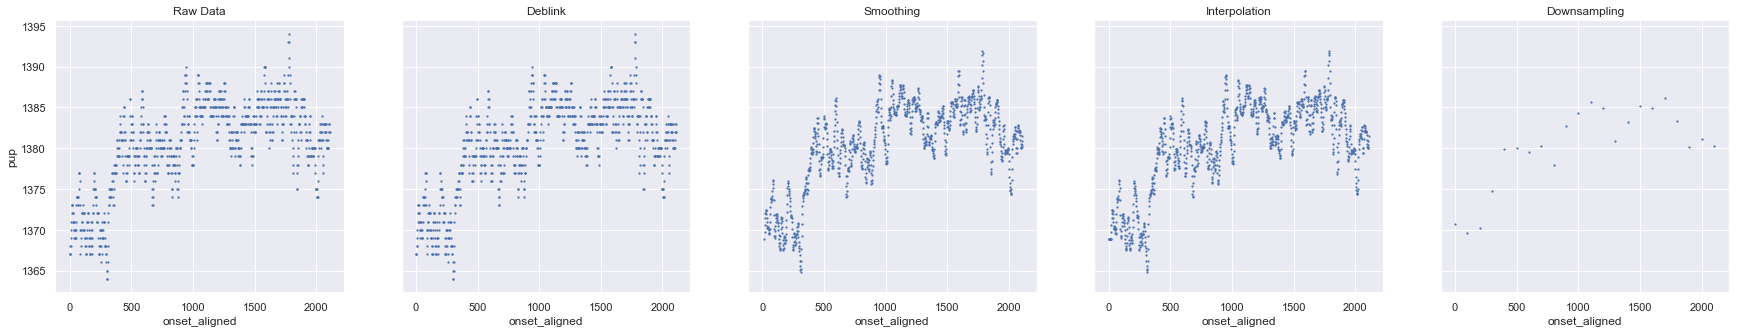

In [135]:
# simple visualization
trialnr = 12

fig, axs = plt.subplots(ncols=5, sharex=True, sharey=True, figsize=(30, 5))
sns.scatterplot(x='onset_aligned', y='pup', data=extracted_samps[extracted_samps.trial_id==trialnr], ax=axs[0], s=5,linewidth=0)
sns.scatterplot(x='onset_aligned', y='pup_deblink_rm', data=rm_samps[rm_samps.trial_id==trialnr], ax=axs[1],s=5,linewidth=0)
sns.scatterplot(x='onset_aligned', y='pup_deblink_rm_smooth', data=smooth_samps[smooth_samps.trial_id==trialnr], ax=axs[2],s=5,linewidth=0)
sns.scatterplot(x='onset_aligned', y='pup_deblink_rm_smooth_interp', data=interp_samps[interp_samps.trial_id==trialnr], ax=axs[3], s=5,linewidth=0)
sns.scatterplot(x='onset_aligned', y='pup_deblink_rm_smooth_interp_resamp', data=resamp_samps[resamp_samps.trial_id==trialnr], ax=axs[4], s=5,linewidth=0)

axs[0].title.set_text('Raw Data')
axs[1].title.set_text('Deblink')
axs[2].title.set_text('Smoothing')
axs[3].title.set_text('Interpolation')
axs[4].title.set_text('Downsampling')